#### Mapping Air Pollution >>> Region of interst (Seoul)
![](files/seoul.PNG)

In [1]:
import json
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import geopandas as gpd


import seaborn as sns
import matplotlib.pyplot as plt


import folium 
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
from IPython.display import display, Markdown

### Reading Air Pollution data in Seoul

In [2]:
stations = pd.read_csv('stations_info.csv')
measurements = pd.read_csv('Measurement_info.csv')
items = pd.read_csv('items_info.csv')

In [3]:
stations.head(2)

,Station code,Station name(district),Address,Latitude,Longitude
0,101,Jongno-gu,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008
1,102,Jung-gu,"15, Deoksugung-gil, Jung-gu, Seoul, Republic o...",37.564263,126.974676


In [4]:
measurements.head(2)

,Measurement date,Station code,Item code,Average value,Instrument status
0,2017-01-01 00:00,101,1,0.004,0
1,2017-01-01 00:00,101,3,0.059,0


In [5]:
items

,Item code,Item name,Unit of measurement,Good(Blue),Normal(Green),Bad(Yellow),Very bad(Red)
0,1,SO2,ppm,0.02,0.05,0.15,1.0
1,3,NO2,ppm,0.03,0.06,0.20,2.0
2,5,CO,ppm,2.00,9.00,15.00,50.0
3,6,O3,ppm,0.03,0.09,0.15,0.5
4,8,PM10,Mircrogram/m3,30.00,80.00,150.00,600.0
5,9,PM2.5,Mircrogram/m3,15.00,35.00,75.00,500.0


In [6]:
# Reading GeoJSON with Seoul administrative borders
with open('seoul/seoul_municipalities.json', 'r', encoding="utf8") as seoul:
    district_borders = json.loads(seoul.read())

In [7]:
# Adding unit to the item name
items['Item name (unit)'] = items['Item name'] + ' (' + items['Unit of measurement'].str.lower() + ')'

# Creating a dict of item codes to item names.
items_dict = {row['Item code']: row['Item name (unit)'] for idx, row in items.iterrows()}

In [8]:
# This is a function generator that creates functions to say if a measurement is good, normal, bad or very bad.
def evaluation_generator(good, normal, bad, vbad):
    def measurement_evaluator(value):
        if(pd.isnull(value) or value < 0):
            return np.nan
        elif(value <= good):
            return 'Good'
        elif(value <= normal):
            return 'Normal'
        elif(value <= bad):
            return 'Bad'
        else:
            return 'Very bad'
        
    return measurement_evaluator

# A dictionary that maps pollutants to functions that evaluate the measurement level.
evaluators = {
    row['Item name (unit)']: evaluation_generator(row['Good(Blue)'], row['Normal(Green)'], row['Bad(Yellow)'], row['Very bad(Red)']) 
    for idx, row in items.iterrows()
}

In [9]:
stations_dict = {row['Station code']: row['Station name(district)'] for idx, row in stations.iterrows()}

In [10]:
# Pivoting table to reduce number of rows
measures = measurements.pivot_table(index=['Measurement date', 'Station code', 'Instrument status'], columns='Item code', values='Average value').reset_index()
measures.columns = measures.columns.rename('')

In [11]:
# Replacing meaningless numbers by labels 
intrument_status = {
    0: 'Normal',
    1: 'Need for calibration',
    2: 'Abnormal',
    4: 'Power cut off',
    8: 'Under repair',
    9: 'Abnormal data',
}
measures['Instrument status'] = measures['Instrument status'].replace(intrument_status)
measures['Station code'] = measures['Station code'].replace(stations_dict)
measures = measures.rename(columns=items_dict)

# Renaming columns
measures = measures.rename(columns={
    'Measurement date': 'Date',
    'Station code': 'Station',
    'Instrument status': 'Status'
})

# Adding levels 
for pol, func in evaluators.items():
    measures[pol.split()[0] + ' Level'] = measures[pol].map(func)
    
# Casting
measures['Date'] = pd.to_datetime(measures['Date'])

# Adding date related columns
weekday_dict = {
    0:'Monday',
    1:'Tuesday',
    2:'Wednesday',
    3:'Thursday',
    4:'Friday',
    5:'Saturday',
    6:'Sunday'
}
measures['Month'] = measures['Date'].dt.month
measures['Year'] = measures['Date'].dt.year
measures['Hour'] = measures['Date'].dt.hour
measures['Day'] = measures['Date'].dt.weekday.replace(weekday_dict)

In [12]:
print('First date:', str(measures['Date'].min()))
print('Last date:', str(measures['Date'].max()))

First date: 2017-01-01 00:00:00
Last date: 2019-12-31 23:00:00


In [13]:
stations_map = folium.Map(location=[37.562600,127.024612], tiles='cartodbpositron', zoom_start=11)

# Add points to the map
for idx, row in stations.iterrows():
    Marker( [row['Latitude'], row['Longitude']], popup=row['Station name(district)']).add_to(stations_map)
    
# Adding borders
folium.GeoJson(
    district_borders,
    name='geojson'
).add_to(stations_map)

# Display the map
stations_map

In [14]:
bad_measures = measures.loc[measures['Status'] != 'Normal', :]
all_measures = measures.copy()
measures = measures.loc[measures['Status'] == 'Normal', :]
overview = measures.groupby('Date').mean().loc[:, 'SO2 (ppm)':'PM2.5 (mircrogram/m3)']

# Adding levels 
for pol, func in evaluators.items():
    overview[pol.split()[0] + ' Level'] = overview[pol].map(func)

In [15]:
overview.sample(5, random_state=50)

,SO2 (ppm),NO2 (ppm),CO (ppm),O3 (ppm),PM10 (mircrogram/m3),PM2.5 (mircrogram/m3),SO2 Level,NO2 Level,CO Level,O3 Level,PM10 Level,PM2.5 Level
Date,,,,,,,,,,,,
2019-01-24 03:00:00,0.00488,0.03260,0.628000,0.01156,37.875,19.640000,Good,Normal,Good,Good,Normal,Normal
2017-09-30 21:00:00,0.00504,0.04720,0.672000,0.01248,51.625,30.833333,Good,Normal,Good,Good,Normal,Normal
2017-09-02 08:00:00,0.00380,0.02016,0.380000,0.01328,16.320,7.280000,Good,Good,Good,Good,Good,Good
2018-05-14 00:00:00,0.00348,0.03848,0.604167,0.00468,43.560,31.920000,Good,Normal,Good,Good,Normal,Normal
2019-02-05 13:00:00,0.00492,0.02064,0.464000,0.03200,114.080,26.800000,Good,Good,Good,Normal,Bad,Normal


In [16]:
general = overview.describe().loc[['min', 'max', 'mean', 'std', '25%', '50%', '75%'],:].T
general['level'] = None
for idx, row in general.iterrows():
    general.loc[idx, 'level'] = evaluators[idx](row['mean'])
    
general.T

,SO2 (ppm),NO2 (ppm),CO (ppm),O3 (ppm),PM10 (mircrogram/m3),PM2.5 (mircrogram/m3)
min,0.00236364,0.004125,0.220833,0.00188,3.12,1.36
max,0.0115417,0.086875,1.764,0.14944,329.583,159.84
mean,0.00431847,0.0286223,0.516274,0.0243726,41.5734,24.0112
std,0.00109203,0.0141368,0.197037,0.0178954,27.8317,17.8767
25%,0.00352,0.01752,0.378261,0.0103333,23.5833,12.24
50%,0.00408,0.0256,0.463636,0.0210909,35.5,19.6733
75%,0.00488,0.03788,0.604,0.0338,52.2752,30.32
level,Good,Good,Good,Good,Normal,Normal


In [17]:
district_pol = measures.groupby(['Station']).mean().loc[:, 'SO2 (ppm)':'PM2.5 (mircrogram/m3)']
district_pol_norm = (district_pol - district_pol.mean()) / district_pol.std()
district_pol_norm.columns = list(map(lambda x: x.split(' ')[0],district_pol_norm.columns))

In [18]:
pollution_map = folium.Map(location=[37.562600,127.024612], tiles='cartodbpositron', zoom_start=11)

# Add points to the map
for idx, row in stations.iterrows():
    Marker([row['Latitude'], row['Longitude']], popup=row['Station name(district)']).add_to(pollution_map)

# Adding choropleth
Choropleth(
    geo_data=district_borders,
    data=district_pol_norm.mean(axis=1), 
    key_on="feature.properties.SIG_ENG_NM", 
    fill_color='YlGnBu', 
    legend_name='Overall pollution in Seoul by region'
).add_to(pollution_map)

pollution_map

In [19]:
reported_day_night = pd.Timestamp(year=2019, month=12, day=11, hour=22)

overview.loc[overview.index == reported_day_night, :]

,SO2 (ppm),NO2 (ppm),CO (ppm),O3 (ppm),PM10 (mircrogram/m3),PM2.5 (mircrogram/m3),SO2 Level,NO2 Level,CO Level,O3 Level,PM10 Level,PM2.5 Level
Date,,,,,,,,,,,,
2019-12-11 22:00:00,0.002957,0.017522,0.378261,0.019739,19.0,12.583333,Good,Good,Good,Good,Good,Good


In [20]:
reported_day_morning = pd.Timestamp(year=2019, month=12, day=11, hour=10)

overview.loc[overview.index == reported_day_morning, :]

,SO2 (ppm),NO2 (ppm),CO (ppm),O3 (ppm),PM10 (mircrogram/m3),PM2.5 (mircrogram/m3),SO2 Level,NO2 Level,CO Level,O3 Level,PM10 Level,PM2.5 Level
Date,,,,,,,,,,,,
2019-12-11 10:00:00,0.004042,0.0315,0.8625,0.024458,156.36,103.96,Good,Normal,Good,Good,Very bad,Very bad


In [21]:
measures.loc[measures['Date'] == reported_day_morning, :'PM2.5 (mircrogram/m3)'].sort_values('PM2.5 (mircrogram/m3)', ascending=False).head(10)

,Date,Station,Status,SO2 (ppm),NO2 (ppm),CO (ppm),O3 (ppm),PM10 (mircrogram/m3),PM2.5 (mircrogram/m3)
667475,2019-12-11 10:00:00,Gangdong-gu,Normal,0.003,0.033,0.9,0.022,192.0,152.0
667464,2019-12-11 10:00:00,Nowon-gu,Normal,0.005,0.036,0.9,0.025,154.0,133.0
667462,2019-12-11 10:00:00,Gangbuk-gu,Normal,0.004,0.032,0.8,0.038,186.0,128.0
667468,2019-12-11 10:00:00,Geumcheon-gu,Normal,0.004,0.034,0.8,0.019,150.0,127.0
667470,2019-12-11 10:00:00,Dongjak-gu,Normal,0.004,0.030,0.8,0.020,175.0,125.0
667450,2019-12-11 10:00:00,Jongno-gu,Normal,0.005,0.036,1.0,0.016,156.0,116.0
667459,2019-12-11 10:00:00,Dongdaemun-gu,Normal,0.004,0.032,0.9,0.022,166.0,113.0
667452,2019-12-11 10:00:00,Yongsan-gu,Normal,0.004,0.029,0.9,0.025,151.0,110.0
667451,2019-12-11 10:00:00,Jung-gu,Normal,0.004,0.032,0.9,0.024,151.0,108.0
667456,2019-12-11 10:00:00,Mapo-gu,Normal,0.005,0.037,0.9,0.021,143.0,107.0


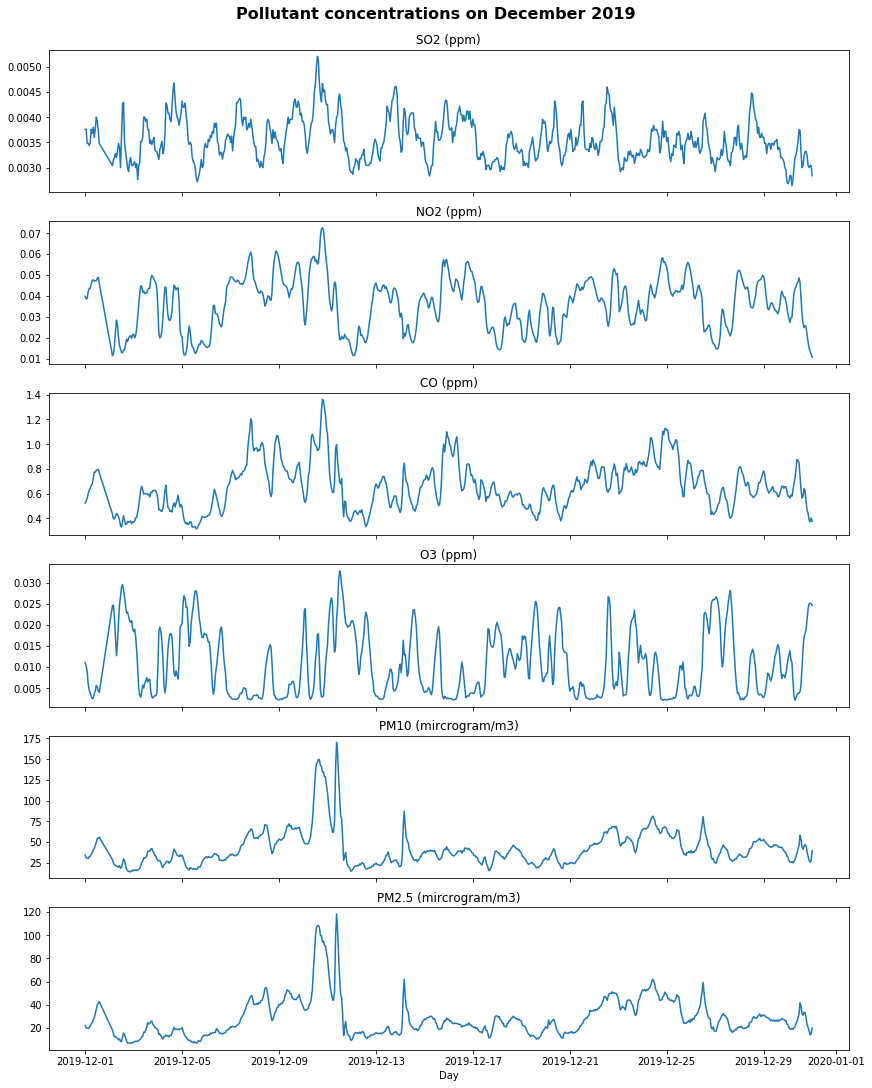

In [28]:
first_day_dec = pd.Timestamp(year=2019, month=12, day=1)
last_day_dec = pd.Timestamp(year=2019, month=12, day=31)

december = overview.loc[(overview.index >= first_day_dec) & (overview.index <= last_day_dec),:]

fig, ax = plt.subplots(6, 1, figsize=(12, 15), sharex=True, constrained_layout=True)
fig.suptitle('Pollutant concentrations on December 2019', fontsize=16, fontweight='bold')
for n, pollutant in enumerate(evaluators.keys()):
    sns.lineplot(data = december[pollutant], ax=ax[n])
    ax[n].set_title(pollutant)
plt.xlabel('Day')
plt.show()

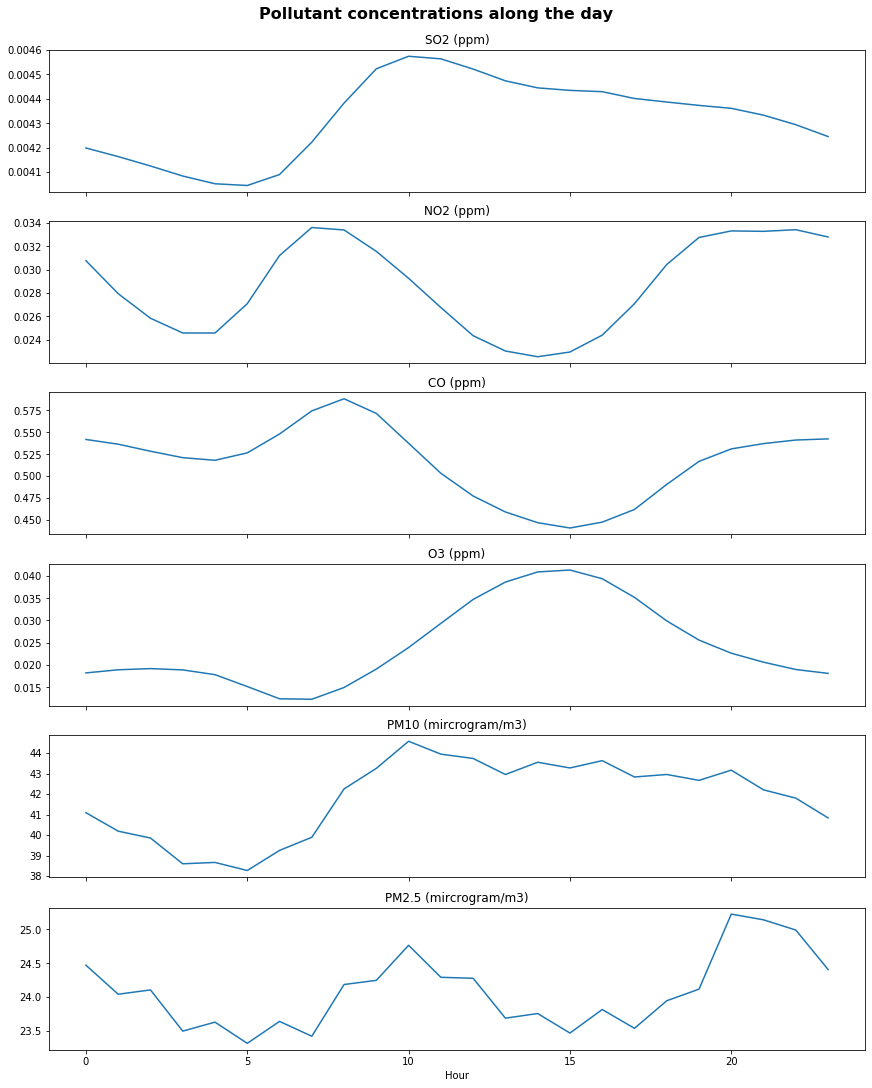

In [23]:
concentration_hour = measures.groupby('Hour').mean()

fig, ax = plt.subplots(6, 1, figsize=(12, 15), sharex=True, constrained_layout=True)
fig.suptitle('Pollutant concentrations along the day', fontsize=16, fontweight='bold')
for n, pollutant in enumerate(evaluators.keys()):
    sns.lineplot(data = concentration_hour[pollutant], ax=ax[n])
    ax[n].set_title(pollutant)
plt.xlabel('Hour')
plt.show()

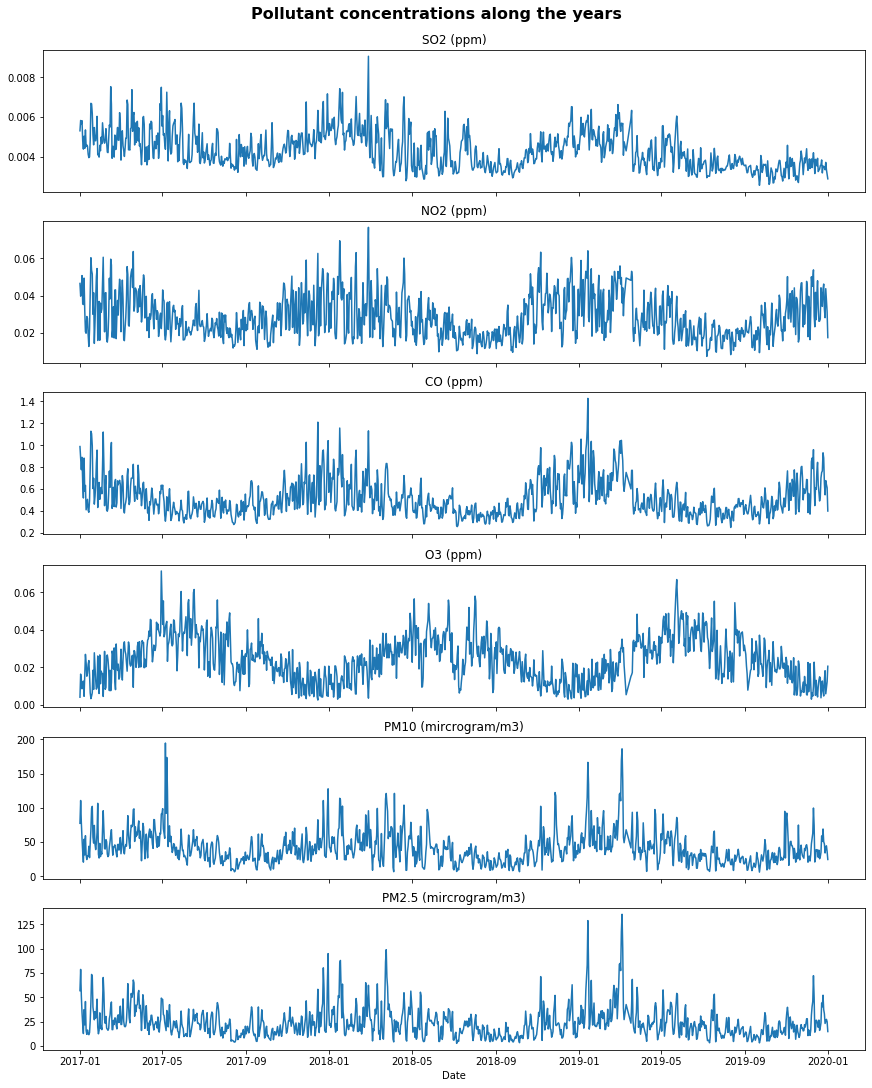

In [24]:
measures_slice = measures.loc[:, ['Date'] + list(evaluators.keys())]
measures_slice['Date'] = measures['Date'].dt.date
concentrations_day = measures_slice.groupby('Date').mean()

fig, ax = plt.subplots(6, 1, figsize=(12, 15), sharex=True, constrained_layout=True)
fig.suptitle('Pollutant concentrations along the years', fontsize=16, fontweight='bold')
for n, pollutant in enumerate(evaluators.keys()):
    sns.lineplot(data = concentrations_day[pollutant], ax=ax[n])
    ax[n].set_title(pollutant)
plt.xlabel('Date')
plt.show()

In [25]:
pwd

'C:\\Users\\pc\\homaair'

In [26]:
ls

 Volume in drive C has no label.
 Volume Serial Number is 9AE4-4B22

 Directory of C:\Users\pc\homaair

06/11/2020  09:47 PM    <DIR>          .
06/11/2020  09:47 PM    <DIR>          ..
06/11/2020  04:18 PM             2,151 .gitignore
06/11/2020  09:46 PM    <DIR>          .ipynb_checkpoints
06/11/2020  09:46 PM             1,080 Air Quality Remote sensing .ipynb
06/03/2020  11:20 PM             6,454 AQI collecting data via api .ipynb
06/11/2020  06:18 PM       253,992,960 AQI.db
06/11/2020  07:24 PM    <DIR>          files
06/11/2020  12:02 PM    <DIR>          Html_AirData
06/11/2020  09:20 PM            29,198 interpolation.ipynb
06/11/2020  05:52 PM               268 items_info.csv
06/11/2020  10:54 AM         1,699,402 Mapping air pollution in Seoul.html
06/11/2020  09:47 PM         1,396,653 Mapping air pollution in Seoul.ipynb
04/03/2020  04:34 PM       124,382,805 Measurement_info.csv
06/11/2020  10:25 AM        93,358,632 Measurement_summary.csv
06/11/2020  07:28 PM    <DIR

In [27]:
jupyter nbconvert --to html 'notebook file.ipynb'

SyntaxError: invalid syntax (<ipython-input-27-40ff387f702c>, line 1)